**Импорт необходимых библиотек**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from bert_score import score
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW

### Важный момент!

In [ ]:
# При обучении модели использовалась версия transformers 4.45.2.
# Во избежание ошибок целесообразно это учитывать
!pip install transformers==4.45.2

**Чтение данных**

In [ ]:
train_df = pd.read_excel('train.xlsx')
train_df.head()

,name,translation,faculty,direction
0,Строение и история развития отложений Мамонто...,Mamontova Gora (the Aldan River): the structur...,Геологический факультет,Науки о Земле
1,"""Hortulus animae"" как особый тип печатного час...","""Hortulus animae"" as a special type of “The Bo...",Исторический факультет,Политические науки и регионоведение; Историчес...
2,"""NHK для школы"" как образовательный проект япо...","""NHK for school"" as an educational project of ...",Факультет журналистики,Средства массовой информации и информационно-б...
3,"""Tavola ritonda"" из Национальной библиотеки Фл...","""Tavola ritonda"" from the National Library in ...",Исторический факультет,Политические науки и регионоведение; Историчес...
4,"""War and peace"" novel by Leo Tolstoy in Chines...",Juxtaposition of zoonyms in the discourse of ...,Высшая школа перевода,Языкознание и литературоведение


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70325 entries, 0 to 70324
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         70325 non-null  object
 1   translation  70325 non-null  object
 2   faculty      70325 non-null  object
 3   direction    70325 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [ ]:
test_df = pd.read_excel('test.xlsx')
test_df.head()

,name,faculty,direction
0,Интегрированные маркетинговые коммуникации в п...,Факультет журналистики,Средства массовой информации и информационно-б...
1,Влияние света на взаимодействие белков в корне...,Биологический факультет,Биологические науки
2,Расчет вероятности двухфотонного поглощения ко...,Химический факультет,Химические науки; Биологические науки
3,Использование временных форм русского глагола ...,Филологический факультет,Образование и педагогические науки; Языкознани...
4,Склонность человека к риску как фактор адаптац...,Экономический факультет,Экономика


**Предобработка данных**

In [ ]:
train_df.shape, test_df.shape

((70325, 4), (200, 3))

In [ ]:
print(f'Кол-во факультетов в обучающей и тестовой выборках соответственно: {len(train_df['faculty'].unique()), len(test_df['faculty'].unique())}')
print(f'Кол-во направлений в обучающей и тестовой выборках соответственно: {len(train_df['direction'].unique()), len(test_df['direction'].unique())}')

Кол-во факультетов в обучающей и тестовой выборках соответственно: (35, 34)
Кол-во направлений в обучающей и тестовой выборках соответственно: (29, 28)


In [ ]:
#Указанный в output факультет пристутствует в train, но отсутствует в test
set(train_df['faculty']) - set(test_df['faculty'])

{'Высшая школа культурной политики и управления в гуманитарной сфере'}

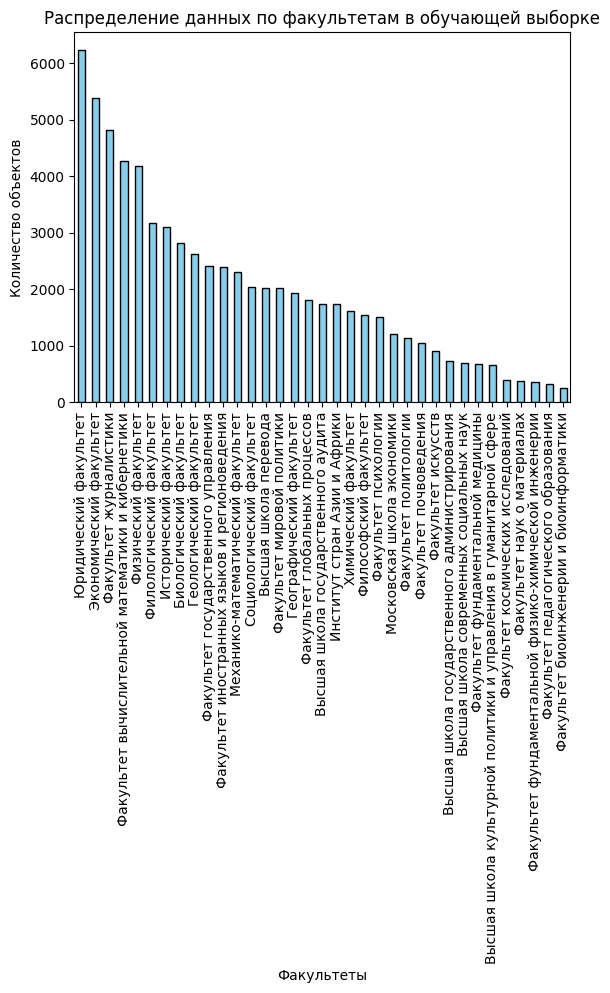

In [ ]:
faculty_counts = train_df['faculty'].value_counts()
faculty_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Распределение данных по факультетам в обучающей выборке')
plt.xlabel('Факультеты')
plt.ylabel('Количество объектов')
plt.show()

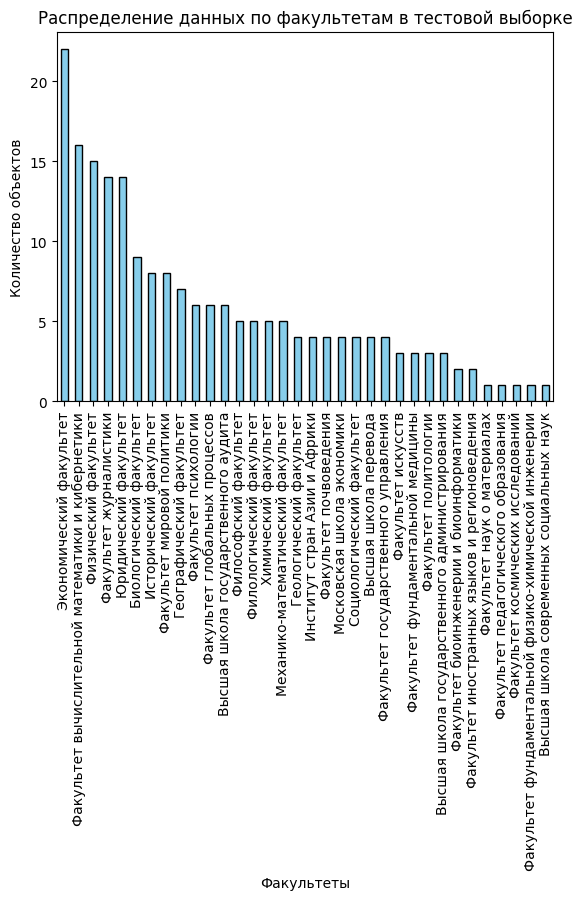

In [ ]:
faculty_counts = test_df['faculty'].value_counts()
faculty_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Распределение данных по факультетам в тестовой выборке')
plt.xlabel('Факультеты')
plt.ylabel('Количество объектов')
plt.show()

In [ ]:
# Убираем дубликаты в нашем целевом признаке - translation
train_df = train_df.drop_duplicates(subset="translation")
train_df.shape

(64048, 4)

In [ ]:
# Удаляем явно не совпадающие пары (name/tarnslation).
# Тоесть строки, где отношение кол-ва слов в первых двух столбцах > 2
train_df['src_count'] = train_df['name'].apply(lambda x: len(x.split()))
train_df['dst_count'] = train_df['translation'].apply(lambda x: len(x.split()))

train_df = train_df[train_df['src_count'] / train_df['dst_count'] < 2]
train_df = train_df[train_df['dst_count'] / train_df['src_count'] < 2]

train_df = train_df.drop(columns=['src_count', 'dst_count'])
train_df.shape

(62979, 4)

In [ ]:
# Удаляем строки названий статей на русском языке, в тексте которых нет символов
# на кириллице. Также чистим лишние символы.
regex = '[а-яА-Я]'
train_df['name'] = train_df['name'].str.replace(r'^(\.|\)|)', '', regex=True)
train_df['name'] = train_df['name'].str.lstrip()
train_df = train_df[train_df['name'].str.contains(regex, regex=True)]
train_df.shape

(62922, 4)

In [ ]:
# Создаем валидационную выборку
MSU_val_df = train_df.sample(n=1000, random_state=20)
train_df.drop(MSU_val_df.index, inplace=True)
train_df.shape

(61922, 4)

In [ ]:
MSU_val_df.head()

,name,translation,faculty,direction
66815,Характеризация свойства свободной порожденност...,Characterization of free generatedness for the...,Механико-математический факультет,Математика и механика; Информатика и вычислите...
43357,Притяжательные прилагательные в Киевской и Нов...,Possessive adjectives in the Kievan and Novgor...,Филологический факультет,Образование и педагогические науки; Языкознани...
53786,Совершенствование музейного менеджмента как ре...,Improving museum management as a resource for ...,Высшая школа культурной политики и управления ...,Политические науки и регионоведение; Культурол...
48938,Редакторская оценка медиапроекта Curious.ru,Editorial assessment of the Curious.ru media p...,Факультет журналистики,Средства массовой информации и информационно-б...
17364,Исследование истории разработки эксплуатационн...,Studying the development history of a producti...,Геологический факультет,Науки о Земле


**Подготовка данных к обучению: создание DataLoader, анализ параметров, загрузка предобученной модели**

In [ ]:
X_train = []
# С помощью префиксов модель учится решать сразу несколько задач
translate_prefix = 'translate ru-en | ' # Префикс для задачи перевода
faculty_classification_prefix = 'classify_faculty: ' # Префикс для задачи определения факультета
direction_classification_prefix = 'classify_direction: ' # Префикс для задачи определения направления

for i in range(len(train_df)):
    row = train_df.iloc[i]
    src = row['name']

    translate_src = translate_prefix + src
    translate_label = row['translation']

    faculty_src = faculty_classification_prefix + src
    faculty_label = row['faculty']

    direction_src = direction_classification_prefix + src
    direction_label = row['direction']

    X_train.append((translate_src, translate_label, faculty_src, faculty_label, direction_src, direction_label))

In [ ]:
X_train[:3] # проверяем получившийся формат

[('translate ru-en | Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Mamontova Gora (the Aldan River): the structure and history of deposits',
  'classify_faculty: Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Геологический факультет',
  'classify_direction: Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Науки о Земле'),
 ('translate ru-en | "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  '"Hortulus animae" as a special type of “The Book of Hours” in 16th century Europe',
  'classify_faculty: "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  'Исторический факультет',
  'classify_direction: "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  'Политические науки и регионоведение; Исторические науки и археология; Искусствоведение'),
 ('translate ru-en | "NHK для школы" как образовательный проект японского телевидения',
  '"NHK for school" as

**Загрузка предобученной модели google-mt5-base, специфированной на русском, английском языках\
Ссылка на HF:**\
https://huggingface.co/cointegrated/rut5-base-multitask

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-multitask")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
#Анализ длины предложений
token_lengths = [len(tokenizer.encode(sentence)) for sentence , _, _, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, sentence, _, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, sentence, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, sentence, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, _, sentence, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, _, _, sentence in X_train]

mean_token_length = np.mean(token_lengths)
median_token_length = np.median(token_lengths)
max_token_length = np.max(token_lengths)
min_token_length = np.min(token_lengths)
std_token_length = np.std(token_lengths)

print(f"Mean Token Length: {mean_token_length}")
print(f"Median Token Length: {median_token_length}")
print(f"Max Token Length: {max_token_length}")
print(f"Min Token Length: {min_token_length}")
print(f"Std Token Length: {std_token_length}")
print(token_lengths)

Mean Token Length: 22.39158672738822
Median Token Length: 23.0
Max Token Length: 99
Min Token Length: 3
Std Token Length: 12.255378801420862


In [ ]:
batch_size = 8
optimal_max_length = 100 # Размер предложения для обучения. Берем максимальный,
# поскольку обрезание в нашей задаче недопустимо

class MultiT5Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        translate_src, translate_label, faculty_src, faculty_label, direction_src, direction_label = self.data[idx]

        translate_inputs = self.tokenizer(translate_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        translate_labels = self.tokenizer(translate_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        faculty_inputs = self.tokenizer(faculty_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        faculty_labels = self.tokenizer(faculty_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        direction_inputs = self.tokenizer(direction_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        direction_labels = self.tokenizer(direction_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {
            "translate_inputs": translate_inputs["input_ids"].squeeze(0),
            "translate_attention_mask": translate_inputs["attention_mask"].squeeze(0),
            "translate_labels": translate_labels["input_ids"].squeeze(0),
            "faculty_inputs": faculty_inputs["input_ids"].squeeze(0),
            "faculty_attention_mask": faculty_inputs["attention_mask"].squeeze(0),
            "faculty_labels": faculty_labels["input_ids"].squeeze(0),
            "direction_inputs": direction_inputs["input_ids"].squeeze(0),
            "direction_attention_mask": direction_inputs["attention_mask"].squeeze(0),
            "direction_labels": direction_labels["input_ids"].squeeze(0),
        }

dataset = MultiT5Dataset(X_train, tokenizer, max_length=optimal_max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader)

7741

In [ ]:
#Определяем параметры обучения
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cpu')

**Цикл обучения (не активирована, поскольку модель обучалась в Kaggle c с приминением GPU, ~2 часа на одну эпоху)**

In [ ]:
# Комментарии в цикле для отладки

epochs = 5
# Важный момент в этой модели - веса, с которыми учитываются разные задачи
weight_translation = 1 # Коэффициент для задачи перевода
weight_faculty_classification = 0.6 # Коэффициент для задачи классификации факультета
weight_direction_classification = 0.6 # Коэффициент для задачи классификации направления

for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_counter = 0 #для отслеживания прогресса

    for batch in dataloader:
        batch_counter += 1

        translate_src = batch["translate_inputs"].to(device)
        translate_attention_mask = batch['translate_attention_mask'].to(device)
        translate_labels = batch['translate_labels'].to(device)

        #print()
        #print('translate_src: ', tokenizer.decode(translate_src[3]))
        #print('translate_label: ', tokenizer.decode(translate_labels[3]))

        outputs_translation = model(input_ids=translate_src, attention_mask=translate_attention_mask, labels=translate_labels)
        loss_translation = outputs_translation.loss

        faculty_src = batch["faculty_inputs"].to(device)
        faculty_attention_mask = batch['faculty_attention_mask'].to(device)
        faculty_labels = batch['faculty_labels'].to(device)

        #print()
        #print('faculty_src: ', tokenizer.decode(faculty_src[3]))
        #print('faculty_label: ', tokenizer.decode(faculty_labels[3]))

        outputs_faculty = model(input_ids=faculty_src, attention_mask=faculty_attention_mask, labels=faculty_labels)
        loss_faculty = outputs_faculty.loss

        direction_src = batch["direction_inputs"].to(device)
        direction_attention_mask = batch['direction_attention_mask'].to(device)
        direction_labels = batch['direction_labels'].to(device)

        #print()
        #print('direction_src: ', tokenizer.decode(direction_src[3]))
        #print('direction_label: ', tokenizer.decode(direction_labels[3]))

        outputs_direction = model(input_ids=direction_src, attention_mask=direction_attention_mask, labels=direction_labels)
        loss_direction = outputs_direction.loss

        total_task_loss = (
            weight_translation * loss_translation +
            weight_faculty_classification * loss_faculty +
            weight_direction_classification * loss_direction
        )

        optimizer.zero_grad()
        total_task_loss.backward()
        optimizer.step()

        total_loss += total_task_loss.item()
        if batch_counter % 1000 == 0:
            print(f'{batch_counter} successfully finished')

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

**Сохранение модели**

In [ ]:
torch.save(model, 'MultiTaskT5.pth')

**Анализ результатов**

In [ ]:
translate_prefix = 'translate ru-en | ' # Префикс для задачи перевода
faculty_classification_prefix = 'classify_faculty: ' # Префикс для задачи определения факультета
direction_classification_prefix = 'classify_direction: ' # Префикс для задачи определения направления

def generate(model, tokenizer, input_text):
# Переводит предложение input_txt с русского на английский
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length",
                       max_length=optimal_max_length)
    output_tokens = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        temperature=0.7,
        top_p=0.9,
        num_beams=5,
        top_k=50,
        num_return_sequences=1
    )
    translation = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    return translation

def test(model, tokenizer, name, predict_translation=True, predict_faculty=False, predict_direction=False):
# Проверка модели на всех трех задачах, name - предложение на русском языке без префиксов
    translation = ''; faculty = ''; direction = ''
    if predict_translation:
        translation_inpt = translate_prefix + name
        translation = generate(model, tokenizer, translation_inpt)
    if predict_faculty:
        faculty_inpt = faculty_classification_prefix + name
        faculty = generate(model, tokenizer, faculty_inpt)
    if predict_direction:
        direction_inpt = direction_classification_prefix + name
        direction = generate(model, tokenizer, direction_inpt)
    return (translation, faculty, direction)

def translate_excel(model, tokenizer, df):
# Переводит DataFrame и возвращает массив переведенных строк
    translations = []
    for i in range(len(df)):
        src = df.iloc[i]['name']
        input_text = translate_prefix + src
        translation = generate(model, tokenizer, input_text)
        translations.append(translation)
    return translations

def avg_bleu(translated, source):
# Считает средний BLEU по двум массивам предложений
    general_bleu = 0
    assert len(translated) == len(source)
    for i in range(len(source)):
        src = source[i]
        translation = translated[i]
        general_bleu += sentence_bleu([src], translation)

    result = general_bleu / len(source)
    return result

In [ ]:
source = 'Особенности финансового обеспечения государственных закупок: вопросы теории и практики'
model_name = 'multiT5-3tasks-titles_scientific_articles.pth'
tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = torch.load(model_name, map_location=torch.device('cpu'))

C:\Users\Michael\AppData\Local\Temp\ipykernel_19168\964420895.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=torch.device('c

In [ ]:
test(model, tokenizer, source, predict_faculty=True, predict_direction=True)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


('Features of financial support for public procurement: issues of theory and practice',
 'Высшая школа государственного аудита',
 'Юриспруденция')

In [ ]:
val_translated = translate_excel(model, tokenizer, MSU_val_df)

In [ ]:
val_true = MSU_val_df['translation'].tolist()

In [ ]:
val_true[9], val_translated[9]

("Features of contemporary Russians' perception of political power and opposition",
 'Features of perception of political power and opposition by modern Russians')

**Подсчет метрик модели**

In [ ]:
T5_BLEU = avg_bleu(val_translated, val_true) # Считаем средний BLEU на валидационной выборке
print('Avg BLEU on validation by T5-multitask =', T5_BLEU)

Avg BLEU on validation by T5-multitask = 0.739241882152652


In [ ]:
_, _, T5_F1 = score(val_true, val_translated, lang='en', verbose=True) # Считаем BERT-score на валидационной выборке
print()
print('F1 by BERTscore on validation by T5-multitask = ', T5_F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/31 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 101.80 seconds, 9.82 sentences/sec

F1 by BERTscore on validation by T5-multitask =  0.9503785967826843


**Сравнение с популярным готовым переводчиком**

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
model_name = "Helsinki-NLP/opus-mt-ru-en"
raw_tokenizer = MarianTokenizer.from_pretrained(model_name)
raw_model = MarianMTModel.from_pretrained(model_name)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
val_raw_transl = translate_excel(raw_model, raw_tokenizer, MSU_val_df)

In [ ]:
raw_BLEU = avg_bleu(val_raw_transl, val_true)
print('Avg BLEU on validation by raw translator =', raw_BLEU)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Avg BLEU on validation by raw translator = 0.49622809140483787


In [ ]:
_, _, raw_F1 = score(val_true, val_raw_transl, lang='en', verbose=True)
print()
print('F1 by BERTscore on validation by  raw translator = ', raw_F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 97.04 seconds, 10.30 sentences/sec

F1 by BERTscore on validation by  raw translator =  0.87066650390625


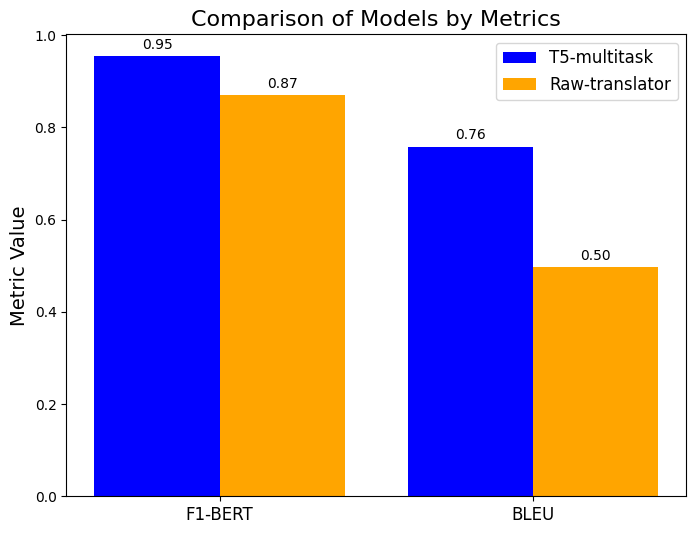

In [ ]:
metrics = ["F1-BERT", "BLEU"]
T5_model = [T5_F1.mean().item(), T5_BLEU]
raw_model = [raw_F1.mean().item(), raw_BLEU]

x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width / 2, T5_model, width, label="T5-multitask", color='blue')
bars2 = ax.bar(x + width / 2, raw_model, width, label="Raw-translator", color='orange')

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Metric Value", fontsize=14)
ax.set_title("Comparison of Models by Metrics", fontsize=16)

ax.legend(fontsize=12)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Сдвиг текста вверх
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()